In [1]:
# Import libraries
from datetime import datetime
from functools import reduce
from itertools import combinations
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xgboost as xgb
import sys
import local_functions as lf
print(sys.version)

3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:48) [Clang 13.0.0 (clang-1300.0.29.30)]


In [2]:
## LIST OF CHEMICAL CLEANINGS DATES ON DF PERIOD

Chemical_days = [
    '15-06-2022',
    '16-06-2022',
    '25-10-2022',
    '27-10-2022',
    '02-01-2023',
    '08-03-2023',
    '15-04-2023',
    '17-04-2023',
    '14-06-2023',
    '21-08-2023',
    '16-10-2023',
    '08-01-2024',
    '18-03-2024']
Chemical_days = [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in Chemical_days]

In [3]:
# Read data
df0 = pd.read_csv('CSVs/R3A_Cicles_Inf.csv')
df0.columns = ['ID','Date','Qair', 'Qperm', 'TMP', 'O2','Temp', 'TSS', 'NH4', 'NO3','Flux', 'Permeab', 'Hz']
df0.sort_values(by = 'Date', inplace = True)
df0.dropna(inplace=True)
df0.drop(['ID'], axis=1, inplace = True)
df0['Date'] = pd.to_datetime(df0['Date'])
df0.reset_index(drop = True, inplace = True)
df0.head(5)

,Date,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz
0,2022-10-05 08:25:20,3906.94,44.0000,-0.156667,5.67800,24.4253,11.7480,0.0,5.70733,11.4583,73.3809,29.0
1,2022-10-05 08:35:44,3902.02,44.6562,-0.157500,1.03125,24.4263,11.6931,0.0,6.18687,11.6292,73.9542,29.0
2,2022-10-05 08:45:46,3903.80,44.5187,-0.157500,0.11625,24.4125,11.7094,0.0,5.73125,11.5934,73.7207,29.0
3,2022-10-05 08:55:46,3909.99,44.8750,-0.158125,0.10125,24.3500,11.6125,0.0,5.60000,11.6862,74.0234,29.0
4,2022-10-05 09:05:46,3909.84,44.6125,-0.157500,0.10125,24.3369,11.5850,0.0,5.01500,11.6178,73.8709,29.0


In [4]:
# DATA TREATMENT
# Set absolute valure for TMP (there is no backwash is flat sheet)
df0['TMP'] = abs(df0['TMP'])

# For de Fouling Rates (FR) calculatios, set time in minutes and tmp to mbar
df0['Minute'] = (df0['Date']-df0['Date'].iloc[0]).dt.total_seconds()/60
df0['TMPmbar'] = df0['TMP']*1000
df0['FR'] = lf.calcualte_slope(df0,n = 5, Name_TMP='TMPmbar',Name_Time='Minute')

# For the chemical cleanings information
df0['Days'] = df0['Date'].dt.date
df0['Chemicals'] = np.zeros(len(df0))
df0['Chemicals'] = df0['Days'].isin(Chemical_days).astype(int)
print(f'N rows with chemicals cleanings: {sum(df0['Chemicals'])}')

# Calcualte days after each chemical cleaning
reset_points = df0['Chemicals'].cumsum()
df0['After_Chemical_h'] = df0.groupby(reset_points)['Minute'].transform(lambda x: (x - x.min()) / 60)
print(f'NaN found: {df0.isna().values.any()}')

# Calculate total resistance
df0['Visco'] = 1.793 * 10**-3 * np.exp(-0.043 * df0['Temp']**0.864)
df0['Resistance'] = (df0['TMP']*3600*1000*1000)/(df0['Flux']*df0['Visco'])
df0.columns

N rows with chemicals cleanings: 559
NaN found: False


Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')

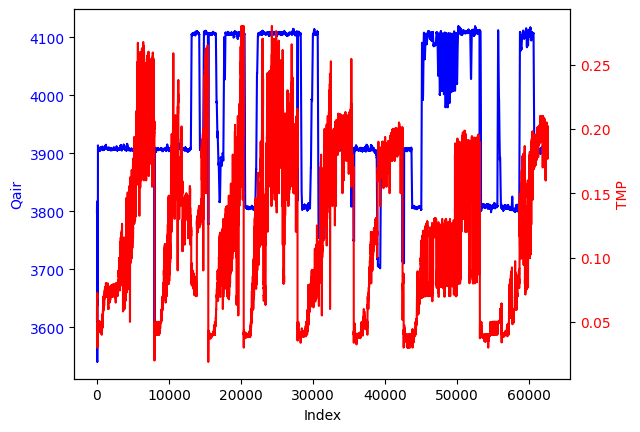

In [5]:
# Set a copy of the DF0 to work with
df = df0.copy()
df['Qair'] = lf.rolling_mean_centered(df['Qair'].values, 100)
df = df.iloc[2370:65041]
df.reset_index(drop = True, inplace = True)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['Qair'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Qair', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['TMP'], color='red')
ax2.set_ylabel('TMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')

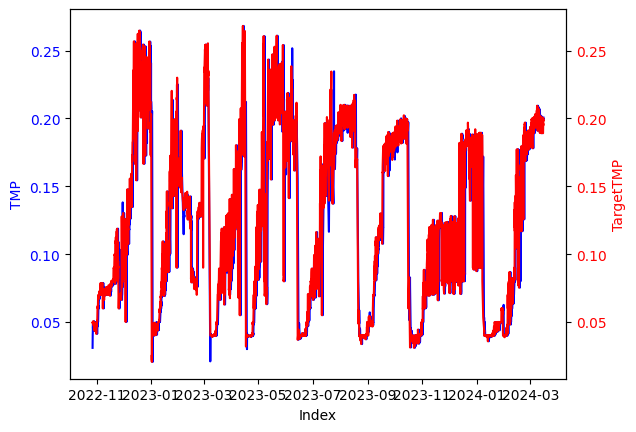

In [6]:
# Resamplt the df to get one value each hour
dfi = df.copy()
dfi.drop(['Days'], axis = 1, inplace = True)
dfi.set_index('Date', inplace = True)
dfi = dfi.resample('60min').median()
target_hours = 24
dfi['TargetTMP'] = dfi['TMP'].shift(-target_hours)
dfi.dropna(inplace = True)

# Plot TMP and target TMP
fig, ax1 = plt.subplots()
ax1.plot(dfi.index, dfi['TMP'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(dfi.index, dfi['TargetTMP'], color='red')
ax2.set_ylabel('TargetTMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

dfi.columns

In [7]:
# Split data for the models

X = dfi[['Qair', 'Temp', 'TSS', 'Flux', 'FR', 'Chemicals','After_Chemical_h', 'Resistance']].copy()
Y = dfi['TargetTMP'].copy()

#X.reset_index(drop = True,inplace=True)
#Y.reset_index(drop = True,inplace=True)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.5, shuffle = True)

  Model        R2       MSE       MAE
0   XGB  0.965617  0.000142  0.006819


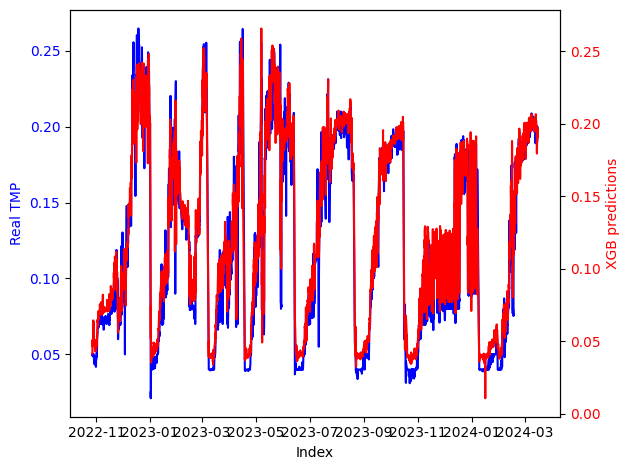

In [8]:
# XGBoost model
mdodel_xgb = xgb.XGBRegressor()
mdodel_xgb.fit(x_train, y_train)
y_xgb = mdodel_xgb.predict(x_test)

# Statistics
xgbr2   = r2_score(y_test,y_xgb)
xgb_mse = mean_squared_error( y_test,y_xgb)
xgb_mae = mean_absolute_error(y_test,y_xgb)

Metrics = pd.DataFrame()
Metrics['Model'] = ['XGB']
Metrics['R2']    = [xgbr2]
Metrics['MSE']   = [xgb_mse]
Metrics['MAE']   = [xgb_mae]
print(Metrics)

Results = y_test.to_frame(name='RealTMP')
Results['Predictions'] = y_xgb
Results = Results.sort_index(ascending=True)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(Results.index, Results['RealTMP'], color='blue', label='Real TMP')
ax1.set_xlabel('Index')
ax1.set_ylabel('Real TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(Results.index, Results['Predictions'], color='red', label='XGB predictions')
ax2.set_ylabel('XGB predictions', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()

Shape of X_train: (4470, 44, 8)
Shape of Y_train: (4470,)
Shape of X_val: (2682, 44, 8)
Shape of Y_val: (2682,)
Shape of X_test: (1789, 44, 8)
Shape of Y_test: (1789,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1130 - root_mean_squared_error: 0.3351 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2370
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0479 - root_mean_squared_error: 0.2186 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15m

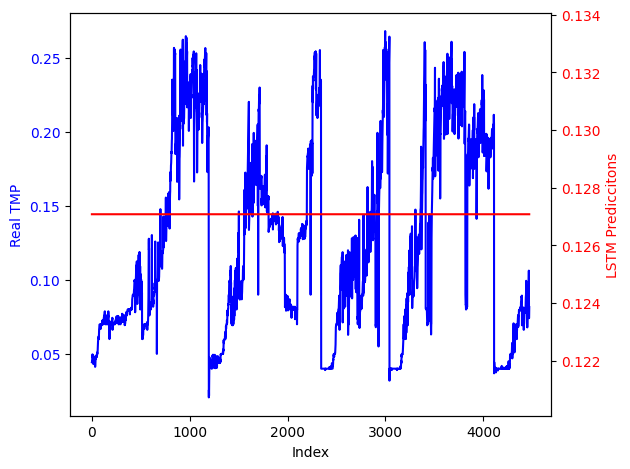

In [11]:
# LSTM attempt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

def df_to_X_y(dfx, dfy, window_size=44):
    dfx_as_np = dfx.to_numpy()
    dfy_as_np = dfy.to_numpy()
    x = []
    y = []
    for i in range(len(dfx_as_np) - window_size):
        row = dfx_as_np[i:i + window_size]
        x.append(row)
        label = dfy_as_np[i + window_size]
        y.append(label)
    return np.array(x), np.array(y)

X_lstm, Y_lstm = df_to_X_y(X, Y)

split_1 = int(0.5 * len(X_lstm))
split_2 = int(0.8 * len(X_lstm))

X_train, Y_train = X_lstm[:split_1], Y_lstm[:split_1]
X_val, Y_val = X_lstm[split_1:split_2], Y_lstm[split_1:split_2]
X_test, Y_test = X_lstm[split_2:], Y_lstm[split_2:]

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

model = Sequential()
model.add(InputLayer((44,8)))
model.add(LSTM(64)) 
model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))
model.summary()

cp = ModelCheckpoint('Model_LSTM.keras', save_best_only=True)
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate = 0.0001),
    metrics=[RootMeanSquaredError()]
)

model.fit(X_train,Y_train, validation_data = (X_val,Y_val),epochs = 10, callbacks = [cp])


model = load_model('Model_LSTM.keras')
train_predictions = model.predict(X_train)
train_results = pd.DataFrame(train_predictions)
train_results['Actuals'] = Y_train
train_results.columns = ['Predictions','RealTMP']

train_results.sort_index(ascending=True)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(train_results.index, train_results['RealTMP'], color='blue', label='Real TMP')
ax1.set_xlabel('Index')
ax1.set_ylabel('Real TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(train_results.index, train_results['Predictions'], color='red', label='XGB predictions')
ax2.set_ylabel('LSTM Prediccitons', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()